# Ajustement d'une loi de distribution unidimensionnelle

## Résumé

Dans ce notebook, nous présentons comment estimer les paramètres d'une loi à partir d'un échantillon.

En particulier, nous explorons les thèmes suivants :
- les classes `Factory`; exemple des classes `NormalFactory` et `WeibullFactory`,
- tests graphique; la classe `DrawQQplot`,
- tests statistiques; les classes `Kolmogorov` et `BIC`,
- les méthodes non paramétriques
 - l'histogramme et la classe `HistogramFactory`
 - les méthodes à noyau et la classe `KernelSmoothing`

In [1]:
import openturns as ot
import numpy as np

## Création de l'échantillon

Nous commençons par créer un échantillon, en utilisant une variable gaussienne centrée-réduite. Nous générons un échantillon de taille $n=100$.

In [2]:
n = 100
data = ot.Normal().getSample(n)

On observe que, à cause de la taille finie de l'échantillon, la moyenne empirique et l'écart-type ne sont pas exactement égales à l'espérance et l'écart-type de la variable aléatoire.

In [3]:
print(data.computeMean())
print(data.computeStandardDeviation())

[0.0647826]
[[ 0.991286 ]]


## Estimation paramétrique

On considère une variable aléatoire associée au vecteur de paramètres $\theta\in\mathbb{R}^p$, où $p$ est le nombre de paramètres. Les méthodes d'estimation paramétriques ont pour objectif d'estimer la valeur du vecteur $\theta$ qui s'ajuste le mieux à un échantillon donné. 

Dans OpenTURNS, deux méthodes sont utilisées pour estimer les paramètres d'une loi en fonction d'un échantillon.
- la classe `MethodOfMomentsFactory` utilise la méthode des moments qui consiste à rechercher la valeur de $\theta$ qui minimise l'écart entre les moments de la distribution et les moments centrés de l'échantillon,
- la classe `MaximumLikelihoodFactory` utilise la méthode du maximum de vraisemblance qui consiste à rechercher la valeur de $\theta$ qui maximise la vraisemblance.

En fonction des distributions, la librairie peut utiliser une combinaison de ces deux méthodes, c'est à dire que certains paramètres peuvent être calculés par la méthode des moments et d'autres peuvent être calculés par la méthode du maximum de vraisemblance. Une autre situation qui peut également arriver est que, dans le but d'aider à la convergence de la méthode du maximum de vraisemblance, on utilise la méthode des moments pour initialiser le calcul.

En pratique, la technique la plus courante consiste à utiliser la `Factory` associée à la distribution dont on souhaite estimer les paramètres. Par exemple, pour la distribution `Normal`, la classe correspondante est la classe `NormalFactory`. Cette classe utilise la méthode des moments ; la théorie montre que, pour la distribution gaussienne la méthode des moments et la méthode du maximum de vraisemblance sont équivalentes. 

In [4]:
X = ot.NormalFactory().build(data)
X

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.0647826] sigma=class=Point name=Unnamed dimension=1 values=[0.991286] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

Dans l'exemple suivant, on créée la variable `Y` par ajustement avec la distribution de Weibull.

In [5]:
Y = ot.WeibullFactory().build(data)
Y

class=Weibull name=Weibull dimension=1 alpha=2.6773 beta=2.57329 gamma=-2.31251

## Validation graphique de l'ajustement

Une méthode fréquemment utilisée pour valider les paramètres de la distribution consiste à créer le QQ-Plot. Il s'agit d'un graphique dans lequel 
- l'axe des abscisses présente les quantiles empiriques de l'échantillon,
- l'axe des ordonnées présente les quantiles de la distribution.

Si les points sont proches de la première bissectrice, alors on considère que l'ajustement est correct. Il arrive fréquemment que l'ajustement est acceptable dans le centre de la distribution (i.e. au milieu du graphique), mais de qualité moindre dans les queues de la distribution. En fonction des objectifs de l'étude, cela peut être acceptable ou non.

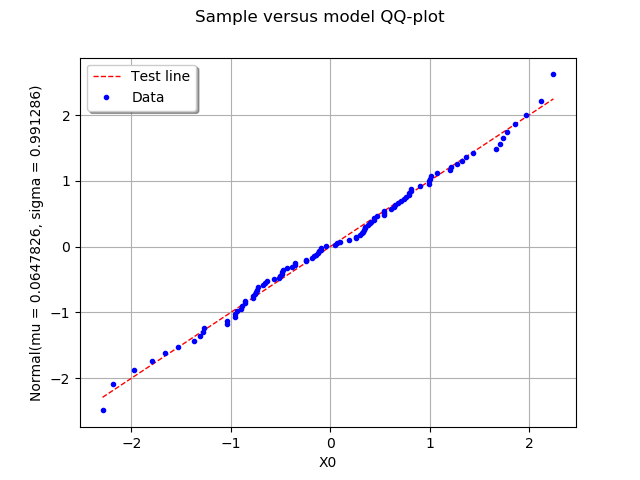

In [6]:
ot.VisualTest.DrawQQplot(data, X)

Dans la boucle `for` suivante, nous comparons l'ajustement avec trois distributions uniformes, beta et log-normale.

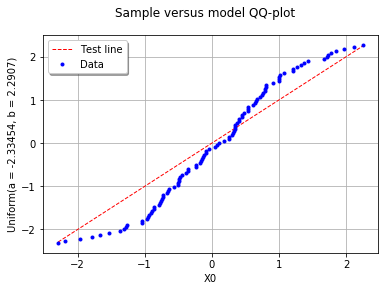

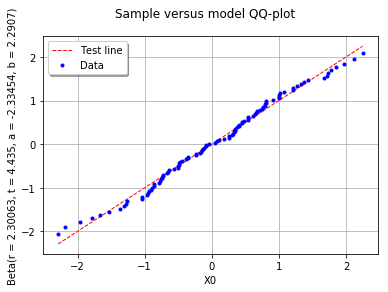

In [7]:
for F in [ot.UniformFactory(),ot.BetaFactory()]:
    T = F.build(data)
    graph = ot.VisualTest.DrawQQplot(data, T)
    ot.viewer.View(graph)

L'ajustement pour la loi uniforme est inacceptable, mais les lois beta et log-normales pourraient convenir.

## Tests statistiques


Les méthodes de test statistiques permettent de quantifier l'écart entre l'échantillon et la loi estimée. Plusieurs méthodes sont disponibles dans la librairie, mais les deux plus fréquemment utilisées sont :
- le test de Kolmogorov-Smirnov (KS), qui quantifie l'écart maximal entre les fonctions de répartition empirique et théoriques,
- le critère BIC, qui permet de pénaliser les distributions associées à un plus grand nombre de paramètres.



## Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov est fondé sur la statistique suivante :
$$
\hat{D}_N = \max_{i=1,...,n} \left|F(x_i) - \frac{i-1}{n}, \frac{i}{n} - F(x_i)\right|
$$
où $F$ est la fonction de répartition à tester, $n$ est la taille de l'échantillon et $\{x_i\}_{i=1,...n}$ est l'échantillon. Cette statistique mesure l'écart entre les fonction de répartition théorique et empirique. 

Faisons l'hypothèse que l'échantillon est issu de la fonction de répartition $F$. Soit $D$ la variable aléatoire associée à la statistique de KS. Soit $p\in[0,1]$ la probabilité d'observer un tel écart :
$$
P\left(D \geq \hat{D}_n\right) = p.
$$
La probabilité $p$ est la *p-valeur* du test. Si $p$ est trop proche de zéro (par exemple si $p<0.05$), alors on considère que l'échantillon n'est pas issu de $F$ et on rejette la loi. Sinon, on ne peut pas rejeter l'hypothèse. 

Deux situations doivent être opposées. 
- Si l'on connait les paramètres de la loi à tester, alors la distribution de la statistique de KS est connue tant pour $n$ grand (distribution asymptotique) que pour $n$ fini. 
- Si les paramètres de la loi ont étés estimés sur l'échantillon alors la distribution de la statistique de KS est inconnue en général. Dans ce cas, on procède par échantillonnage. 

Si les paramètres de la loi sont estimés sur l'échantillon, alors l'adéquation est meilleure avec les données. Cela qui diminue la valeur de la statistique de test, d'autant plus  que la distribution possède plus de paramètres à ajuster. En d'autres termes, les faibles valeurs de la statistique de test sont plus fréquentes. 

## Cas 1 : les paramètres de la loi sont connus

Selon la situation dans laquelle on se situe, ce n'est pas le même constructeur de la classe `FittingTest.Kolmogorov` qui doit être utilisé.

Premièrement, plaçons nous dans la situation où les paramètres sont connus. Dans cette situation, le second argument de la classe `Kolmogorov` est la distribution testée, c'est à dire un objet de type `Distribution`.

Le script suivant teste l'hypothèse 

H0 = "l'échantillon est issu de la distribution gaussienne de paramètres $\mu=0$ et $\sigma=1$"

In [8]:
T = ot.Normal()
ksresult = ot.FittingTest.Kolmogorov(data, T)
ksresult

class=TestResult name=Unnamed type=Kolmogorov Normal binaryQualityMeasure=true p-value threshold=0.05 p-value=0.490259 description=[Normal(mu = 0, sigma = 1) vs sample Normal]

In [9]:
ksresult.getPValue()

0.49025908234293103

In [10]:
ksresult.getThreshold()

0.05

La méthode `getBinaryQualityMeasure` renvoit vrai si on ne peut pas rejeter l'hypothèse H0. Les esprits les plus téméraires affirmeraient qu'on "accepte l'hypothèse", mais les statisticiens sont de tempérament prudent.

In [11]:
ksresult.getBinaryQualityMeasure()

True

## Cas 2 : les paramètres de la loi sont estimés

Deuxièmement, on se place dans la situation où les paramètres sont estimés sur l'échantillon. Dans cette situation, on doit utiliser le second argument de la classe `Kolmogorov` est la méthode d'estimation de la distribution à tester, c'est à dire un objet de type `Factory`.

Pour estimer la distribution de la statistique de test, nous commençons par configurer la taille de l'échantillon utilisé par l'algorithme.

In [12]:
ot.ResourceMap.SetAsUnsignedInteger("FittingTest-KolmogorovSamplingSize",1000)

In [13]:
dist = ot.NormalFactory()
ksresult = ot.FittingTest.Kolmogorov(data, dist)
ksresult

class=TestResult name=Unnamed type=Kolmogorov Normal binaryQualityMeasure=true p-value threshold=0.05 p-value=0.558 description=[Normal(mu = 0.0647826, sigma = 0.991286) vs sample Normal]

In [14]:
ksresult.getPValue()

0.558

La p-valeur est proche de 0.55, ce qui implique que l'hypothèse ne peut pas être rejetée.

In [15]:
ksresult.getBinaryQualityMeasure()

True

## Cas 3 : les paramètres de la loi sont estimés, mais l'utilisateur commet une erreur

Troisièmement, on se place dans la situation où les paramètres sont estimés sur l'échantillon mais l'utilisateur fait comme si les paramètres étaient connus. Dans cette situation, la p-valeur calculée par la librairie sera fausse et plus grande que la p-valeur correcte : on risque d'accepter à tort. C'est une erreur de la part de l'utilisateur.

In [16]:
dist = ot.NormalFactory().build(data)
ksresult = ot.FittingTest.Kolmogorov(data, dist)
ksresult

class=TestResult name=Unnamed type=Kolmogorov Normal binaryQualityMeasure=true p-value threshold=0.05 p-value=0.879738 description=[Normal(mu = 0.0647826, sigma = 0.991286) vs sample Normal]

In [17]:
ksresult.getPValue()

0.8797383423677565

On observe que la p-valeur, fausse, vaut 0.88 alors que la p-valeur correcte est 0.8.

In [18]:
ksresult.getBinaryQualityMeasure()

True

## Critère BIC

Le critère Bayesian Information Criterion est un critère qui permet de sélectionner la distribution parmi une collection de $K$ distributions à tester. 

Pour $i=1,...,K$, soit $L_i$ la valeur du maximum de vraisemblance du i-ème modèle et soit $p_i$ le nombre de paramètres du i-ème modèle. Par exemple, si l'on considère la loi gaussienne, alors $p_i=2$, puisque cette loi est déterminée par les deux paramètres $\mu$ et $\sigma$. Le critère BIC implémenté dans la librairie est 
$$
BIC_i = -2 \frac{\log(L_i)}{n} + \frac{p_i \log(n)}{n} 
$$
où $n$ est la taille de l'échantillon. 

Le critère consiste à préférer la distribution associée à la plus petite valeur du critère BIC. 

D'une part, lorsque la distribution dépend d'un grand nombre de paramètres (i.e. lorsque $p_i$ est grand, alors l'ajustement est meilleur ce qui implique que la log-vraisemblance est plus grande et donc $-\log(L_i)$ est plus petit. D'autre part, puisque le critère dépend du nombre de paramètres $p_i$, ce critère défavorise les distributions ayant un nombre de paramètres élevé. D'une manière globale, le critère réalise une pondération entre la qualité de l'ajustement et le nombre de paramètres. 

Dans la session suivante, on évalue le critère BIC pour la distribution gaussienne. 

In [19]:
ot.FittingTest.BIC(data, ot.Normal())

2.8148953639402152

Dans l'absolu, ce critère n'est pas utile ; il n'est utile que par comparaison avec les autres distributions. Dans la boucle `for` suivante, on teste les lois gaussienne, uniforme, beta et log-normale et on évalue le critère BIC.

In [20]:
print("Name, BIC")
for F in [ot.NormalFactory(),ot.UniformFactory(),ot.BetaFactory(),ot.LogNormalFactory()]:
    T = F.build(data)
    name = T.getName()
    bic = ot.FittingTest.BIC(data, T)
    print("%s: %.4f" % (name, bic))

Name, BIC
Normal: 2.8104
Uniform: 3.0631
Beta: 2.8490
LogNormal: 2.8103


On observe que la plus petite valeur de BIC est atteinte pour les lois gaussienne et log-normale. La valeur pour la loi beta est significativement plus grande et la loi uniform est disqualifiée.

## Estimation non paramétrique : l'histogramme

Soit $\{x_i\}_{i=1,...,n}$ un échantillon unidimensionnel de taille $n$. La méthode la plus simple pour créer un histogramme consiste à créer des classes dont la largeur $h$ est fixée et constante. On note $a$ et $b$ les valeurs minimales et maximales dans l'échantillon :
$$
a = \min_{i=1,...,n} x_i, \qquad b = \max_{i=1,...,n} x_i.
$$
Pour $i=1,...,m$, on note $t_i\in\mathbb{R}$ les bords des classes où $m$ est le nombre de classes et on fait l'hypothèse que le bords sont triés par ordre strictement croissants :
$$
t_1 < t_2 < \ldots < t_m.
$$
Dans le cas particulier où les classes sont de largeur constante, on a :
$$
h = t_i - t_{i-1} 
$$
pour $i=2,...,m$. 
Les classes sont les intervalles $[t_{i-1},t_i[\subset\mathbb{R}$ pour $i=2,...,m$. 
Soit $n_i$ le nombre de valeurs de l'échantillon dans la classe $[t_{i-1},t_i]$ :
$$
n_i = \#\left\{x_j\in [t_{i-1},t_i[, \, j=1,...,n\right\}
$$
pour $i=1,...,m-1$. 
Soit 
$$
y_i = \frac{n_i}{w_i},
$$
où $w_i$ est un poids permettant d'assurer la normalisation de l'histogramme : 
$$
\sum_{i=1}^{m-1} y_i (t_{i+1} - t_{i}) = 1.
$$
Par exemple, avec une largeur de classe constante égale à $h$, on a 
$$
w_i = \frac{n}{h}.
$$
L'histogramme est la densité de probabilité définie par l'équation :
\begin{equation}
f_X(x) = \sum_{i=1}^{m-1} y_i\;\mathbb{1}_{[t_i,t_{i+1}]}(x)
\end{equation}
pour tout $x\in[a,b]$. 

La valeur par défaut de la largeur de classe $h$ est la règle de Silverman qui minimise le critère AMISE :
$$
h = \left(\frac{24 \sqrt{\pi}}{n}\right)^{1/3}  \sigma
$$
où $\sigma$ est l'écart-type empirique non biaisé.

In [21]:
histo = ot.HistogramFactory().build(data)
histo

class=Histogram name=Histogram dimension=1 first=-2.29006 width=class=Point name=Unnamed dimension=7 values=[0.648042,0.648042,0.648042,0.648042,0.648042,0.648042,0.648042] height=class=Point name=Unnamed dimension=7 values=[0.0771555,0.108018,0.401209,0.262329,0.401209,0.169742,0.123449]

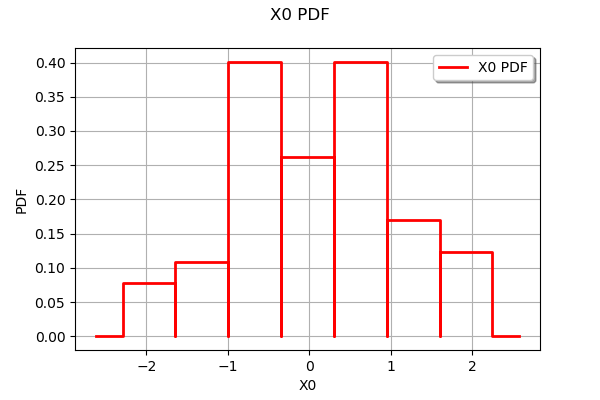

In [22]:
histo.drawPDF()

## Méthodes à noyau

Soit $k$ une loi de distribution univariée. Par définition, cela implique :
$$
\int_{-\infty}^{+\infty} k(x) =1.
$$
L'estimateur à noyau est la densité de probabilité définie par :
$$
f_{KS}(x) = \frac{1}{n\,h} \sum_{i=1}^n k \left( \frac{x-x_i}{h} \right)
$$
où $h$ est la largeur de bande et $n$ est la taille de l'échantillon.

En pratique, les deux noyaux les plus utilisés sont :
- le noyau gaussien, i.e. 
$$
k(x) = \varphi(x) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{x^2}{2}\right)
$$
- le noyau d'Epanechnikov :
$$
k(x) = \frac{3}{4} (1-x^2)
$$
pour tout $x\in[-1,1]$ et $k(x) = 0$ sinon.

Le noyau d'Epanechnikov est optimal au sens de l'erreur moyenne quadratique. 

In [23]:
ksfactory = ot.KernelSmoothing()
ksfactory

<openturns.dist_bundle2.KernelSmoothing; proxy of <Swig Object of type 'OT::KernelSmoothing *' at 0x000001BA9F06F2A0> >

In [24]:
KS = ksfactory.build(data)

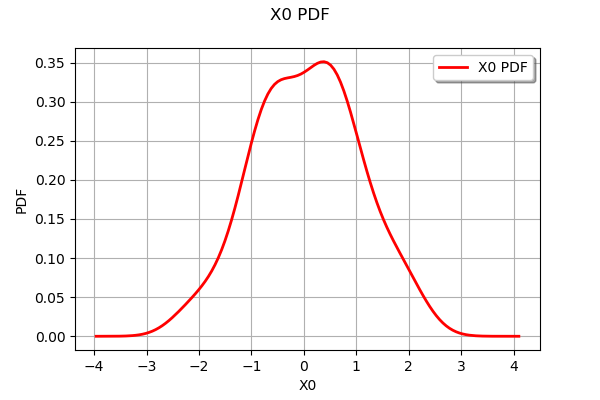

In [25]:
KS.drawPDF()

Dans la boucle `for` suivante, on compare le noyau gaussien et le noyau d'Epanechnikov en termes de test de Kolmogorov-Smirnov et de critère BIC.

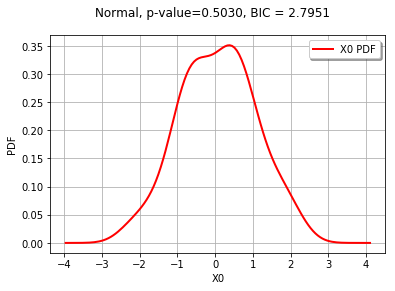

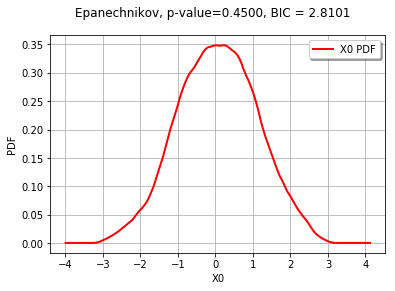

In [26]:
colors = ["red", "green"]
kernels = [ot.Normal(), ot.Epanechnikov()]
for k in kernels:
    name = k.getName()
    ksfactory = ot.KernelSmoothing(k)
    ksresult = ot.FittingTest.Kolmogorov(data, ksfactory)
    pval = ksresult.getPValue()
    KS = ksfactory.build(data)
    bic = ot.FittingTest.BIC(data, KS)
    graph = KS.drawPDF()
    graph.setTitle("%s, p-value=%.4f, BIC = %.4f" % (name,pval, bic))
    ot.viewer.View(graph)

## Références

- http://openturns.github.io/openturns/master/theory/data_analysis/maximum_likelihood.html
- http://openturns.github.io/openturns/master/theory/data_analysis/kolmogorov_test.html
- http://openturns.github.io/openturns/master/theory/data_analysis/bic.html
- https://en.wikipedia.org/wiki/Kernel_%28statistics%29

## Annexe

Dans ce paragraphe, on explore le calcul de la largeur de classe dans un histogramme par la règle de Silverman.

La version robuste de la règle de Silverman utilise les quantiles de l'échantillon. 

In [27]:
s = data.computeQuantilePerComponent(0.75)[0] - data.computeQuantilePerComponent(0.25)[0]
h = (24 * np.sqrt(np.pi)/n)**(1./3.) * s / (2.0 * ot.DistFunc_qNormal(0.75))
h

0.8067172117500124

In [28]:
f = ot.HistogramFactory()
f.computeSilvermanBandwidth(data,True)

0.8067172117500124

La règle de Silverman utilise l'écart-type empirique non biaisé.

In [29]:
sigma = data.computeStandardDeviationPerComponent()[0]
h = (24 * np.sqrt(np.pi)/n)**(1./3.) * sigma
h

0.7455229983115491

In [30]:
f = ot.HistogramFactory()
f.computeSilvermanBandwidth(data,False)

0.7455229983115491

In [31]:
p = histo.getParametersCollection()[0]
p

class=PointWithDescription name=X0 dimension=15 description=[first,width_0,height_0,width_1,height_1,width_2,height_2,width_3,height_3,width_4,height_4,width_5,height_5,width_6,height_6] values=[-2.29006,0.648042,0.0771555,0.648042,0.108018,0.648042,0.401209,0.648042,0.262329,0.648042,0.401209,0.648042,0.169742,0.648042,0.123449]

TODO : pourquoi la largeur ne correspond-elle pas à aucune des deux variantes de la règle de Silverman ?